In [ ]:
# all the imports
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path='/content/drive/My Drive/AML/'

Basic setting up


In [ ]:
# define constants and other set up
image_size = (128, 128, 3)

# set image data format manually to avoid potential confusion
K.set_image_data_format('channels_last')

# set up tensorboard
#tensorboard supporter to tensorflow

#NAME = '40-mse_blocked-{}'.format(int(time.time()))
#tensorboard = TensorBoard(log_dir='logs/{}'.format(NAME))

Autoencoder architecture

In [ ]:
#utility model: plots layers
from tensorflow.keras.utils import plot_model
plot_model(autoencoder, to_file='model.png', show_shapes=True)

Perceptual loss function

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
tf.config.experimental_run_functions_eagerly(True)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)

def perceptual_loss(y_true, y_pred):
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))
    

58892288/58889256 [==============================] - 1s 0us/step


Combining pixel and perceptual loss function

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
tf.config.experimental_run_functions_eagerly(True)

def pixel_perceptual_loss(y_true, y_pred):
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_size)
    loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
    loss_model.trainable = False
    perceptual=K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))
    pixel= ((y_true-y_pred)**2)/(128*128*3)
    combined_loss= (0.5*pixel) + perceptual
    return (combined_loss)

In [ ]:
input_img = Input(shape=image_size)  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

x = UpSampling2D((2, 2))(encoded)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

#optimizer=tf.keras.optimizers.RMSprop(0.001)
#autoencoder.compile(loss='perceptual_loss', metrics = ['accuracy'])
autoencoder.compile(optimizer='adam', loss=perceptual_loss, metrics = ['accuracy'])
#autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics = ['accuracy'])
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 32)        0     

Load data

In [ ]:
# load in the training data: pixelated/blurred/blocked and corresponding original images
# make sure you load the correct training data file here
#xontent cannot be read in one go
pickle_in = open(path+'training_datasets/noisy_6000.pickle', 'rb')
X1 = pickle.load(pickle_in)
X2 = pickle.load(pickle_in)
X3 = pickle.load(pickle_in)
X4 = pickle.load(pickle_in)
X5 = pickle.load(pickle_in)
X6 = pickle.load(pickle_in)
X = np.concatenate((X1,X2, X3, X4, X5, X6))
del X1, X2, X3, X4, X5, X6

pickle_in1 = open(path+'training_datasets/original_6000.pickle', 'rb')
y1 = pickle.load(pickle_in1)
y2 = pickle.load(pickle_in1)
y3 = pickle.load(pickle_in1)
y4 = pickle.load(pickle_in1)
y5 = pickle.load(pickle_in1)
y6 = pickle.load(pickle_in1)
y = np.concatenate((y1,y2,y3,y4,y5,y6))
del y1,y2,y3,y4,y5,y6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


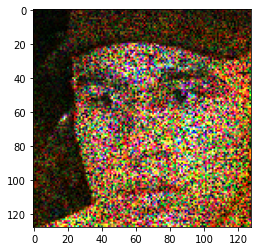

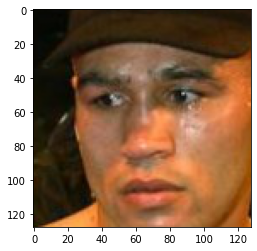

In [ ]:
plt.imshow(X[5999]) # obfuscated
plt.show()
plt.imshow(y[5999]) # obfuscated
plt.show()

Split data into training and testing


In [ ]:
from sklearn.model_selection import train_test_split
print(X.shape)
print(y.shape)

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

print(X_train.shape)
print(y_train.shape)

(6000, 128, 128, 3)
(6000, 128, 128, 3)
(5400, 128, 128, 3)
(5400, 128, 128, 3)


Train the autoencoder

In [ ]:
history=autoencoder.fit(X, y, epochs=7, batch_size=128, shuffle=True, validation_data=(X_test, y_test))

Epoch 1/7
47/47 [==============================] - 136s 3s/step - loss: 31.6965 - accuracy: 0.8147 - val_loss: 21.2736 - val_accuracy: 0.8079
Epoch 2/7
47/47 [==============================] - 124s 3s/step - loss: 18.2217 - accuracy: 0.8411 - val_loss: 16.6852 - val_accuracy: 0.8666
Epoch 3/7
47/47 [==============================] - 124s 3s/step - loss: 15.4191 - accuracy: 0.8748 - val_loss: 14.7477 - val_accuracy: 0.8864
Epoch 4/7
47/47 [==============================] - 124s 3s/step - loss: 14.0395 - accuracy: 0.8881 - val_loss: 13.6403 - val_accuracy: 0.8905
Epoch 5/7
47/47 [==============================] - 125s 3s/step - loss: 13.1754 - accuracy: 0.9055 - val_loss: 12.9334 - val_accuracy: 0.9132
Epoch 6/7
47/47 [==============================] - 124s 3s/step - loss: 12.5676 - accuracy: 0.9133 - val_loss: 12.4315 - val_accuracy: 0.9112
Epoch 7/7
47/47 [==============================] - 124s 3s/step - loss: 12.1402 - accuracy: 0.9159 - val_loss: 12.1268 - val_accuracy: 0.9166


In [ ]:
# save the autoencoder model
autoencoder.save(path+'trained_models/perceptual_mse_6000.h5')


Plotting loss function


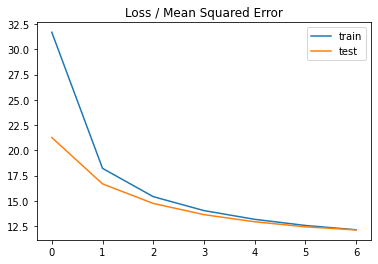

In [ ]:
from matplotlib import pyplot
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Demo with a test image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


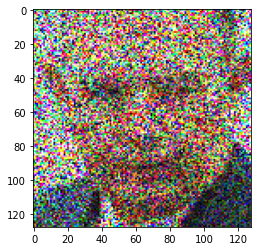

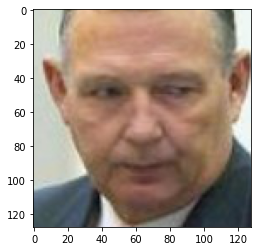

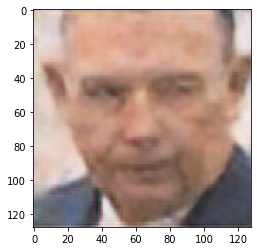

In [ ]:
predicted = autoencoder.predict(np.array([X_test[2]]))

plt.imshow(X_test[2]) # obfuscated
plt.show()
plt.imshow(y_test[2]) # original
plt.show()
plt.imshow(predicted[0]) # predicted
plt.show()


Evaluation using SSIM

In [ ]:
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
predicted = autoencoder.predict(np.array([X_test[2]]))
img=y_test[2]
img_x=X_test[2]
img_noise=predicted[0]
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min(),multichannel=True)
ssim_noise_new = ssim(img, img_x,
                  data_range=img_x.max() - img_x.min(),multichannel=True)
ssim_noise_original = ssim(img, img,
                  data_range=img.max() - img.min(),multichannel=True)

In [ ]:
print (ssim_noise)
print (ssim_noise_new)
print (ssim_noise_original)

0.7145509608758706
0.22352650687323475
1.0


Evaluation using PSNR


In [ ]:
import numpy 
import math
import cv2
original = y_test[2]
predicted = autoencoder.predict(np.array([X_test[2]]))
contrast = predicted[0]
#contrast = y_test[2]
#contrast = X_test[2]
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
      return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(original,contrast)
print(d)

69.34611809295201
